In [160]:
import gymnasium as gym
import torch
from torch.autograd import Variable
import torch.nn as nn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
import copy
import numpy as np
from collections import namedtuple

In [161]:
class DQN():
    def __init__(self, input, output, hidden_count, lr):
        self.model = nn.Sequential(
            nn.Linear(input, hidden_count),
            nn.ReLU(),
            nn.Linear(hidden_count, output)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.criterion = torch.nn.MSELoss()

    def update(self, state, action):
        q_val = self.model(torch.Tensor(state))
        loss = self.criterion(q_val, Variable(torch.Tensor(action)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        with torch.no_grad():
            return self.model(torch.Tensor(state))
        
    def save(self, file_name):
        torch.save(self.model, file_name)

In [162]:
def greedy_policy(agent, eps, action_count):
    def policy(stage):
        if random.random() < eps:
            return random.randint(0, action_count - 1)
        else:
            q_val = agent.predict(stage)
            return torch.argmax(q_val).item()
    return policy

In [163]:
class Parameters():
    def __init__(self
                 , episode_count = 1
                 , episode_update = 1
                 , replay_size = 1
                 , epsilone = 0.1
                 , epsilon_decay = 1.
                 , gamma = 1.
                                        ):
        self.episode_count = episode_count
        self.episode_update = episode_update
        self.replay_size = replay_size
        self.epsilone = epsilone
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.memlength = episode_count


In [164]:
def modern_reward(state, new_state, new_reward):
    
    #new_reward += (
    #- 100 * (new_state[0] - state[0])   # X, 
    #- 100 * (new_state[1] - state[1])   # Y, 
    #- 100 * (new_state[2] - state[2])   # Vx,
    #- 100 * (new_state[3] - state[3]))   # Vy,
    
    #new_reward += - 1 * abs(new_state[3])
    #
    #new_reward += - 10 * abs(new_state[5])   # Vθ,
    #new_reward += - 1 * abs(new_state[4])   # θ, 
    #new_reward += (50 * (new_state[6])   # Л
    #            +  50 * (new_state[7]))  # П

    return new_reward

In [165]:
def q_learning(params, env, seed, action_count, agent, agent_target):
    
    env.reset(seed=seed)
    random.seed(seed)
    torch.manual_seed(seed)

    total_reward_episode = np.zeros(params.episode_count)
    memory = deque(maxlen=params.memlength)
    epsilone = params.epsilone

    for n in tqdm(range(params.episode_count)):

        if n % params.episode_update == 0:
            agent_target.model.load_state_dict(agent.model.state_dict())

        state, _ = env.reset()
        policy = greedy_policy(agent, epsilone, action_count)

        is_done = False
        is_break = False

        while not is_done and not is_break:
            action = policy(state)

            new_state, reward, is_done, is_break, _ = env.step(action)

            reward = modern_reward(state, new_state, reward)

            memory.append((state,action,new_state,reward,(is_done or is_break)))

            if len(memory) > params.replay_size * 2:
                replay_mem = random.sample(memory, params.replay_size)
                states = []
                q_values = []

                for m_state,m_action,m_new_state,m_reward, m_done in replay_mem:
                    states.append(m_state)
                    q_value = agent.predict(m_state).tolist()
                    if m_done:
                        q_value[m_action]  = m_reward
                    else:
                        q_value_new = agent_target.predict(m_new_state)
                        q_value[m_action] = m_reward + params.gamma * torch.argmax(q_value_new).item()
                    q_values.append(q_value)

                agent.update(states, q_values)
            else:
                q_value = agent.predict(state).tolist()
                if is_done or is_break:
                    q_value[action]  = reward
                    agent.update(state, q_value)
                    break

                q_value_new = agent.predict(new_state)
                q_value[action] = reward + params.gamma * torch.argmax(q_value_new).item()

                agent.update(state, q_value)

            state = new_state

            total_reward_episode[n] += reward

        epsilone = max(epsilone * params.epsilon_decay, 0.01)

    return total_reward_episode

In [166]:
env = gym.envs.make("LunarLander-v2")

In [167]:
env.observation_space
#  X, координата посадочного модуля,
#  Y, координата посадочного модуля
#  Vx, горизонтальная скорость
#  Vy, вертикальная скорость
#  θ, ориентация в пространстве
#  Vθ, угловая скорость
#  Ллевая стойка касается земли (да/нет)
#  Правая стойка касается земли (да/нет)

Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)

In [168]:
params = Parameters(episode_count=600, 
                    episode_update=10, 
                    replay_size=20, 
                    epsilone=0.3, 
                    epsilon_decay=0.99, 
                    gamma=0.99)

variant = namedtuple('variant', ['n_hidden', 'lr', 'replay_size','episode_update'])

n_variant = []

seed = 42
last_episode = 100

n_hidden_options = [50, 100]
lr_options = [0.001, 0.003]
replay_size_options = [20, 30]
episode_update_options = [30, 35]

for n_hidden in n_hidden_options:
    for lr in lr_options:
        for replay_size in replay_size_options:
            for episode_update in episode_update_options:
                n_variant.append(variant(
                    n_hidden=n_hidden,
                    lr=lr,
                    replay_size=replay_size,
                    episode_update=episode_update
                ))

action_count = env.action_space.n
state_count = env.observation_space.shape[0]

total_reward_episode_end = []

#for n_hidden, lr, replay_size, episode_update in n_variant:
if True:
    n_hidden, lr, replay_size, episode_update = n_variant[0]
    
    params.replay_size = replay_size
    params.episode_update = episode_update

    agent = DQN(state_count, action_count, n_hidden, lr)
    agent_target = DQN(state_count, action_count, n_hidden, lr)
    total_reward_episode = q_learning(params, env, seed, action_count, agent, agent_target)

    print(n_hidden, lr, replay_size, episode_update, sum(total_reward_episode[-last_episode:])/last_episode)
    total_reward_episode_end = total_reward_episode


100%|██████████| 600/600 [08:32<00:00,  1.17it/s]

50 0.001 20 30 -292.4521279715851


In [169]:
agent.save('../agents/lunar_lander_v2_dqn.pth')

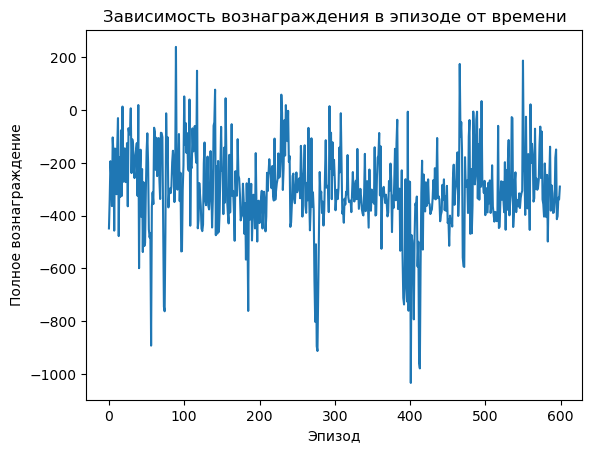

In [170]:
plt.plot(total_reward_episode_end)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [174]:
reward_end_episode = total_reward_episode_end[-last_episode:]
sum(reward_end_episode)/last_episode

-292.4521279715851

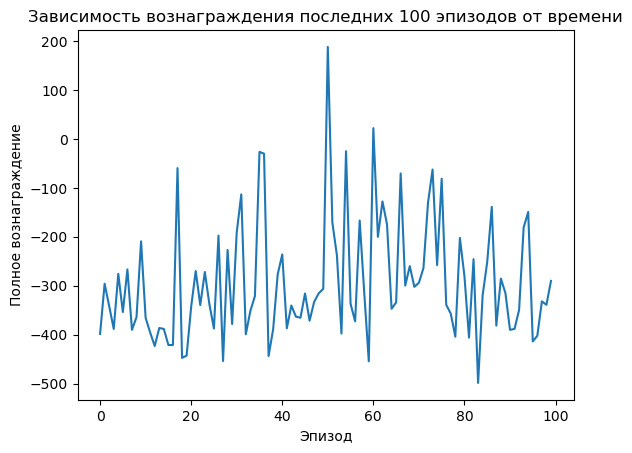

In [173]:
plt.plot(reward_end_episode)
plt.title('Зависимость вознаграждения последних {} эпизодов от времени'.format(last_episode))
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()